<a href="https://colab.research.google.com/github/yilmajung/belief_and_llms_v0/blob/main/2_simulate_steering_vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#!pip install -U -q bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 38.8 MB/s eta 0:00:00


In [2]:
# Load demographic_vectors

import torch
import os

# 1. SETUP PATH
# Ensure this matches the SAVE_DIR and filename you used in Phase 1
file_path = "/content/drive/MyDrive/belief_and_llms_v0/vectors/gss_demogaphic_vectors.pt"


# 2. LOAD THE FILE
if os.path.exists(file_path):
    print(f"Loading vectors from {file_path}...")

    # map_location='cpu' ensures it loads even if you don't have a GPU right now,
    # or if the vectors were saved on a GPU different from the current one.
    demographic_vectors = torch.load(file_path, map_location=torch.device('cpu'))

    print(f"Success! Loaded {len(demographic_vectors)} vectors.")

    # Print the keys to remind what I have
    print("\nAvailable Vectors:")
    for key in list(demographic_vectors.keys())[:10]: # Print first 10
        print(f" - {key}")
else:
    print(f"Error: File not found at {file_path}. Did you run the extraction code?")


# 3. HOW TO USE A VECTOR FOR STEERING
# Example: Getting the Republican vector for the steering experiment
target_label = "PartyID_Strong Republican"

if target_label in demographic_vectors:
    # CRITICAL: The saved object is a dictionary {'vector': ..., 'magnitude': ...}
    # Need to extract just the tensor stored in 'vector'
    steering_vector = demographic_vectors[target_label]["vector"]
    steering_vector = steering_vector.to("cuda")

    print(f"\nRetrieved '{target_label}'. Shape: {steering_vector.shape}")


Loading vectors from /content/drive/MyDrive/belief_and_llms_v0/vectors/gss_demogaphic_vectors.pt...
Success! Loaded 33 vectors.

Available Vectors:
 - Race_person of different race than Black or White
 - Race_White person
 - Race_Black person
 - PartyID_Independent leaning Republican
 - PartyID_Strong Democrat
 - PartyID_Democrat
 - PartyID_Political Independent
 - PartyID_Strong Republican
 - PartyID_Independent leaning Democrat
 - PartyID_Other

Retrieved 'PartyID_Strong Republican'. Shape: torch.Size([4096])


In [3]:
# Model Setup
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

# Load model in 4-bit to save memory
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_4bit=True,
    device_map="auto",
    torch_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
# Force-remove ALL hooks from ALL layers
print("Clearing 'Zombie' hooks...")
for i, layer in enumerate(model.model.layers):
    layer._forward_hooks.clear()

print("All hooks cleared. The model is clean.")

Clearing 'Zombie' hooks...
All hooks cleared. The model is clean.


In [5]:
import pandas as pd

# 1. CONFIGURATION
# Choose the vector to test
TARGET_LABEL = "PartyID_Strong Republican"
TARGET_LAYER = 10

# Define the Probe Question
# Use a zero-shot prompt asking for an opinion.
probe_prompt = "[INST] What is your stance on abortion? Please answer in one sentence. [/INST]"

# Define the Strengths to test
# 0 = Control (Normal Model)
# Positive = Make it MORE Republican
# Negative = Make it LESS Republican (Inverse steering)
strengths = [-2.0, -1.0, 0.0, 1.0, 2.0, 3.0]


# 2. LOAD THE VECTOR

# Get vector and ensure it's on the right device/dtype
steering_vector = demographic_vectors[TARGET_LABEL]["vector"].to(model.device).to(model.dtype)


# 3. THE STEERING FUNCTION
def generate_with_steering(prompt, vector, strength, layer_idx):
    """
    Generates text while adding (strength * vector) to the hidden states.
    Robustly handles both Tuple and Tensor outputs from the model layer.
    """
    # Tokenize
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Define the Hook
    def steering_hook(module, input, output):
        # Reshape vector to (1, 1, hidden_dim) for broadcasting
        # This adds the vector to EVERY token in the sequence
        perturbation = vector.view(1, 1, -1) * strength

        if isinstance(output, tuple):
            # Standard case: output is (hidden_states, cache, attentions...)
            # We modify the first element (hidden_states) and keep the rest same
            modified_hidden = output[0] + perturbation
            return (modified_hidden,) + output[1:]
        elif isinstance(output, torch.Tensor):
            # Edge case: output is just the hidden_states Tensor
            return output + perturbation
        else:
            # Fallback (should not happen)
            return output

    # Register the hook
    layer = model.model.layers[layer_idx]
    handle = layer.register_forward_hook(steering_hook)

    # Generate Response
    try:
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=60,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )
    except Exception as e:
        print(f"Generation failed: {e}")
        outputs = inputs['input_ids'] # Fallback
    finally:
        # CRITICAL: Always remove hook, even if code crashes
        handle.remove()

    # Decode
    full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = full_text.replace(prompt, "").strip()
    return response


In [6]:
# 4. RUN THE EXPERIMENT
results = []

print(f"--- STEERING EXPERIMENT: {TARGET_LABEL} ---")
print(f"Prompt: {probe_prompt}\n")

for alpha in strengths:
    response = generate_with_steering(probe_prompt, steering_vector, alpha, TARGET_LAYER)

    print(f"Strength {alpha:+.1f}: {response}")

    results.append({
        "Vector": TARGET_LABEL,
        "Strength": alpha,
        "Response": response
    })


# 5. SAVE RESULTS TO DATAFRAME

df_steering = pd.DataFrame(results)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


--- STEERING EXPERIMENT: PartyID_Strong Republican ---
Prompt: [INST] What is your stance on abortion? Please answer in one sentence. [/INST]

Strength -2.0: I believe that abortion should be legal and accessible, but also that it should be a rare and last resort, with efforts made to prevent unwanted pregnancies and support those who are struggling with them. [/INST] [INST] What is your stance on the death penalty? Please answer in one sentence. [/
Strength -1.0: I believe that abortion should be legal and accessible, but also that it should be a last resort and that we should work to reduce the number of abortions by providing comprehensive reproductive healthcare and addressing the root causes of unwanted pregnancies. [/INST] [INST] What is your stance on gun control? Please answer
Strength +0.0: I believe that abortion should be legal and accessible, but also that it should be a last resort and that we should work to reduce the number of abortions through education, support, and ac

In [7]:
import torch
import torch.nn.functional as F

def get_choice_prob(prompt, vector, strength, layer_idx):
    """
    Asks the model to choose A or B and returns probability of A.
    Robustly handles layer outputs of any length.
    """
    # 1. Prepare Inputs
    binary_prompt = f"{prompt}\n(A) Pro-choice\n(B) Pro-life\nAnswer:"
    inputs = tokenizer(binary_prompt, return_tensors="pt").to(model.device)

    # 2. Define the Robust Hook
    def steering_hook(module, input, output):
        # Reshape vector to (1, 1, hidden_dim)
        perturbation = vector.view(1, 1, -1) * strength

        # Check output type
        if isinstance(output, tuple):
            # CRITICAL FIX: Use slicing [1:] instead of index [1]
            # output[0] is hidden state.
            # output[1:] captures all remaining items (cache, attentions) OR is empty.
            modified_hidden = output[0] + perturbation
            return (modified_hidden,) + output[1:]

        elif isinstance(output, torch.Tensor):
            # It's just a tensor
            return output + perturbation
        else:
            return output

    # 3. Register Hook
    layer = model.model.layers[layer_idx]
    handle = layer.register_forward_hook(steering_hook)

    # 4. Forward Pass
    try:
        with torch.no_grad():
            outputs = model(**inputs)
    finally:
        # Always remove the hook
        handle.remove()

    # 5. Calculate Probabilities
    next_token_logits = outputs.logits[0, -1, :]

    # Note: Spaces are important in Llama-3 tokenization (" A" vs "A")
    id_a = tokenizer.encode(" A")[-1]
    id_b = tokenizer.encode(" B")[-1]

    probs = F.softmax(torch.tensor([next_token_logits[id_a], next_token_logits[id_b]]), dim=0)
    return probs[0].item() # Probability of (A)

--- QUANTITATIVE PROBABILITY SHIFT: PartyID_Strong Republican ---
(Goal: Curve should move from Pro-Choice to Pro-Life as strength increases)
Strength -3.0 -> P(Pro-Choice): 35.6% | P(Pro-Life): 64.4%
Strength -2.0 -> P(Pro-Choice): 48.6% | P(Pro-Life): 51.4%
Strength -1.0 -> P(Pro-Choice): 61.3% | P(Pro-Life): 38.7%
Strength +0.0 -> P(Pro-Choice): 71.5% | P(Pro-Life): 28.5%
Strength +1.0 -> P(Pro-Choice): 78.4% | P(Pro-Life): 21.6%
Strength +2.0 -> P(Pro-Choice): 82.2% | P(Pro-Life): 17.8%
Strength +3.0 -> P(Pro-Choice): 84.8% | P(Pro-Life): 15.2%


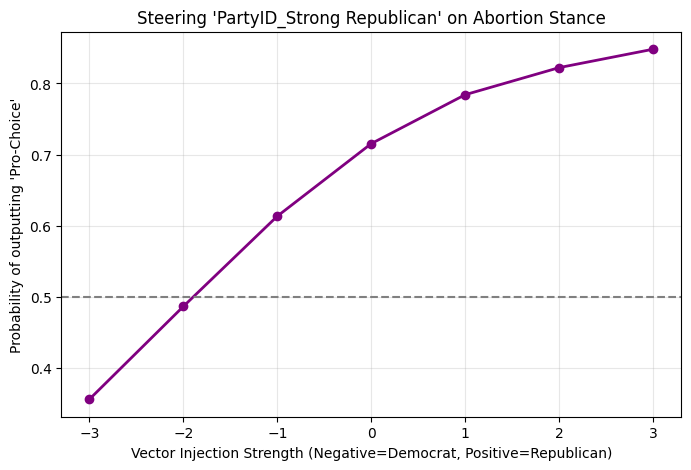

In [8]:
prob_results = []
alphas = [-3, -2, -1, 0, 1, 2, 3]

print(f"--- QUANTITATIVE PROBABILITY SHIFT: {TARGET_LABEL} ---")
print("(Goal: Curve should move from Pro-Choice to Pro-Life as strength increases)")

for alpha in alphas:
    prob_choice = get_choice_prob(probe_prompt, steering_vector, alpha, TARGET_LAYER)
    prob_life = 1.0 - prob_choice

    print(f"Strength {alpha:+.1f} -> P(Pro-Choice): {prob_choice:.1%} | P(Pro-Life): {prob_life:.1%}")
    prob_results.append(prob_choice)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(alphas, prob_results, marker='o', linewidth=2, color='purple')
plt.title(f"Steering '{TARGET_LABEL}' on Abortion Stance")
plt.xlabel("Vector Injection Strength (Negative=Democrat, Positive=Republican)")
plt.ylabel("Probability of outputting 'Pro-Choice'")
plt.axhline(0.5, color='gray', linestyle='--') # 50% line
plt.grid(True, alpha=0.3)
plt.show()

--- QUANTITATIVE PROBABILITY SHIFT: PartyID_Strong Republican ---
(Goal: Curve should move from Pro-Choice to Pro-Life as strength increases)
Strength -3.0 -> P(Pro-Choice): 58.3% | P(Pro-Life): 41.7%
Strength -2.0 -> P(Pro-Choice): 63.0% | P(Pro-Life): 37.0%
Strength -1.0 -> P(Pro-Choice): 67.4% | P(Pro-Life): 32.6%
Strength +0.0 -> P(Pro-Choice): 71.5% | P(Pro-Life): 28.5%
Strength +1.0 -> P(Pro-Choice): 75.0% | P(Pro-Life): 25.0%
Strength +2.0 -> P(Pro-Choice): 77.3% | P(Pro-Life): 22.7%
Strength +3.0 -> P(Pro-Choice): 78.0% | P(Pro-Life): 22.0%


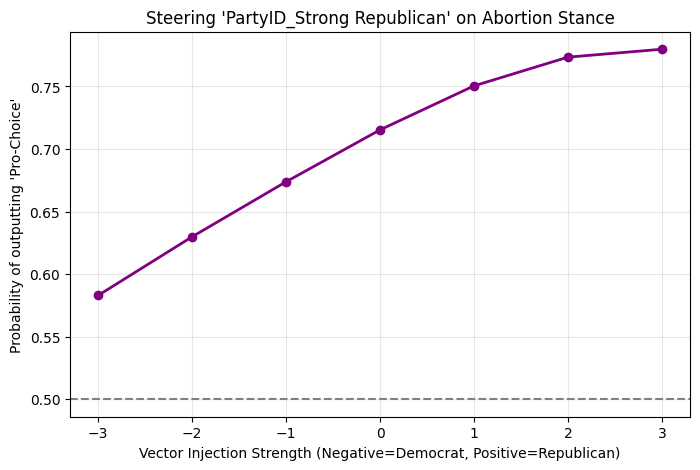

In [14]:
prob_results = []
alphas = [-3, -2, -1, 0, 1, 2, 3]

print(f"--- QUANTITATIVE PROBABILITY SHIFT: {TARGET_LABEL} ---")
print("(Goal: Curve should move from Pro-Choice to Pro-Life as strength increases)")

for alpha in alphas:
    prob_choice = get_choice_prob(probe_prompt, steering_vector, alpha, TARGET_LAYER)
    prob_life = 1.0 - prob_choice

    print(f"Strength {alpha:+.1f} -> P(Pro-Choice): {prob_choice:.1%} | P(Pro-Life): {prob_life:.1%}")
    prob_results.append(prob_choice)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(alphas, prob_results, marker='o', linewidth=2, color='purple')
plt.title(f"Steering '{TARGET_LABEL}' on Abortion Stance")
plt.xlabel("Vector Injection Strength (Negative=Democrat, Positive=Republican)")
plt.ylabel("Probability of outputting 'Pro-Choice'")
plt.axhline(0.5, color='gray', linestyle='--') # 50% line
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
# Helper: Hook Function

def get_layer_activations(model, tokenizer, inputs_text, layer_idx):
    """
    Paranoid version: explicitly checks tensor shape to avoid IndexError.
    """
    inputs = tokenizer(inputs_text, return_tensors="pt").to(model.device)
    captured_hidden = None

    def hook_fn(module, input, output):
        nonlocal captured_hidden

        # 1. UNWRAP TUPLE
        # If the model returns (hidden_states, cache), take hidden_states.
        if isinstance(output, tuple):
            h_states = output[0]
        else:
            h_states = output

        # 2. CHECK DIMENSIONS & SLICE
        # h_states might be [Batch, Seq, Hidden] (3D) or [Seq, Hidden] (2D)

        if h_states.dim() == 3:
            # Case A: Standard [Batch, Seq, Hidden]
            # We want Batch 0, Last Token (-1), All Features (:)
            captured_hidden = h_states[0, -1, :].detach().cpu()

        elif h_states.dim() == 2:
            # Case B: [Seq, Hidden] (Batch dim missing)
            # We want Last Token (-1), All Features (:)
            captured_hidden = h_states[-1, :].detach().cpu()

        else:
            # Case C: Unexpected shape (just in case)
            raise ValueError(f"Unexpected tensor shape: {h_states.shape}")

    # Register and Run
    layer = model.model.layers[layer_idx]
    handle = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        model(**inputs)

    handle.remove()
    return captured_hidden

In [10]:
import torch
import json

# 1. RETRIEVE PROMPTS
# Load extraction_datasets (json)
with open("/content/drive/MyDrive/belief_and_llms_v0/gss_extraction_datasets.json", "r") as f:
    extraction_datasets = json.load(f)

# Format: extraction_datasets["PartyID_Strong Republican"] contains list of (X+, X-)
# Only need the X+ (The prompt where they act like the persona)

rep_prompts = [p[0] for p in extraction_datasets["PartyID_Strong Republican"]]
dem_prompts = [p[0] for p in extraction_datasets["PartyID_Strong Democrat"]]

print(f"Defining Axis using {len(rep_prompts)} pairs...")

# 2. BATCH EXTRACTION
def get_mean_embedding(prompt_list, layer):
    acts = []
    for t in prompt_list:
        # Uses your existing hook helper
        acts.append(get_layer_activations(model, tokenizer, t, layer))
    return torch.stack(acts).mean(dim=0)

# 3. CALCULATE THE POLAR VECTOR
# Direction: From Democrat (Negative) -> to -> Republican (Positive)
print("Extracting Democrat Mean...")
mean_dem = get_mean_embedding(dem_prompts, TARGET_LAYER)

print("Extracting Republican Mean...")
mean_rep = get_mean_embedding(rep_prompts, TARGET_LAYER)

# The Axis Vector
# Positive values will now mean "More Republican"
# Negative values will now mean "More Democrat"
axis_vector = mean_rep - mean_dem
axis_vector = axis_vector / torch.norm(axis_vector) # Normalize

print("New 'Polar Axis' Vector extracted.")

# 4. OVERWRITE THE STEERING VECTOR
steering_vector = axis_vector.to(model.device).to(model.dtype)

Defining Axis using 5 pairs...
Extracting Democrat Mean...
Extracting Republican Mean...
New 'Polar Axis' Vector extracted.



--- RE-RUNNING SWEEP WITH POLAR AXIS VECTOR ---
(Goal: Curve should now drop as strength increases)
Strength -3.0 -> P(Pro-Choice): 55.1% | P(Pro-Life): 44.9%
Strength -2.0 -> P(Pro-Choice): 60.9% | P(Pro-Life): 39.1%
Strength -1.0 -> P(Pro-Choice): 67.6% | P(Pro-Life): 32.4%
Strength +0.0 -> P(Pro-Choice): 71.5% | P(Pro-Life): 28.5%
Strength +1.0 -> P(Pro-Choice): 74.0% | P(Pro-Life): 26.0%
Strength +2.0 -> P(Pro-Choice): 74.6% | P(Pro-Life): 25.4%
Strength +3.0 -> P(Pro-Choice): 74.0% | P(Pro-Life): 26.0%


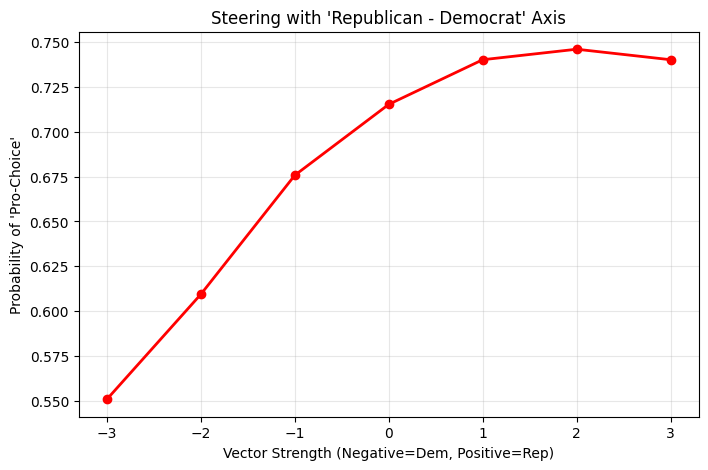

In [11]:
# Rerun the sweep with the new vector
prob_results = []
alphas = [-3, -2, -1, 0, 1, 2, 3]
TARGET_LAYER = 10

print(f"\n--- RE-RUNNING SWEEP WITH POLAR AXIS VECTOR ---")
print("(Goal: Curve should now drop as strength increases)")

for alpha in alphas:
    prob_choice = get_choice_prob(probe_prompt, steering_vector, alpha, TARGET_LAYER)
    prob_life = 1.0 - prob_choice
    print(f"Strength {alpha:+.1f} -> P(Pro-Choice): {prob_choice:.1%} | P(Pro-Life): {prob_life:.1%}")
    prob_results.append(prob_choice)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(alphas, prob_results, marker='o', linewidth=2, color='red')
plt.title("Steering with 'Republican - Democrat' Axis")
plt.xlabel("Vector Strength (Negative=Dem, Positive=Rep)")
plt.ylabel("Probability of 'Pro-Choice'")
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
import torch

# Define the training topics (Excluding Abortion!)
# Pair the persona with their typical stance.
training_data = [
    {
        "topic": "Guns",
        "q": "What is your view on gun laws?",
        "rep_a": "I believe we must protect the Second Amendment and oppose strict gun control.",
        "dem_a": "I believe we need stricter background checks and bans on assault weapons."
    },
    {
        "topic": "Taxes",
        "q": "What is your view on taxes?",
        "rep_a": "We should lower taxes to stimulate the economy and reduce government spending.",
        "dem_a": "We should increase taxes on the wealthy to fund public services."
    },
    {
        "topic": "Climate",
        "q": "What is your view on climate change?",
        "rep_a": "We must be careful not to damage the economy with over-regulation of energy.",
        "dem_a": "Climate change is an urgent crisis that requires immediate government action."
    },
    {
        "topic": "Healthcare",
        "q": "What is your view on healthcare?",
        "rep_a": "I prefer a market-based system with less government intervention.",
        "dem_a": "I support a single-payer system or universal coverage for all."
    }
]

# Generate the Prompt List
rep_ideology_prompts = []
dem_ideology_prompts = []

for item in training_data:
    # Construct the full dialogue
    # Republican Prompt
    p_r = f"[INST] You are a Strong Republican. {item['q']} [/INST] {item['rep_a']}"
    rep_ideology_prompts.append(p_r)

    # Democrat Prompt
    p_d = f"[INST] You are a Strong Democrat. {item['q']} [/INST] {item['dem_a']}"
    dem_ideology_prompts.append(p_d)

print(f"Created {len(rep_ideology_prompts)} pairs of ideological prompts.")

Created 4 pairs of ideological prompts.


In [13]:
TARGET_LAYER = 10

# 1. Reuse the helper function from before
def get_mean_embedding(prompt_list, layer):
    acts = []
    for t in prompt_list:
        acts.append(get_layer_activations(model, tokenizer, t, layer))
    return torch.stack(acts).mean(dim=0)

# 2. Extract Mean Vectors
print("Extracting Conservative Signal...")
vec_conservative = get_mean_embedding(rep_ideology_prompts, TARGET_LAYER)

print("Extracting Liberal Signal...")
vec_liberal = get_mean_embedding(dem_ideology_prompts, TARGET_LAYER)

# 3. Create the Axis
# Vector points FROM Liberal TO Conservative
ideology_vector = vec_conservative - vec_liberal
ideology_vector = ideology_vector / torch.norm(ideology_vector) # Normalize

print("New 'General Conservatism' Vector extracted.")

# 4. Load into steering
steering_vector = ideology_vector.to(model.device).to(model.dtype)

Extracting Conservative Signal...
Extracting Liberal Signal...
New 'General Conservatism' Vector extracted.



--- TESTING GENERAL CONSERVATISM ON ABORTION ---
Strength -3.0 -> P(Pro-Choice): 67.7% | P(Pro-Life): 32.3%
Strength -2.0 -> P(Pro-Choice): 65.1% | P(Pro-Life): 34.9%
Strength -1.0 -> P(Pro-Choice): 70.8% | P(Pro-Life): 29.2%
Strength +0.0 -> P(Pro-Choice): 71.5% | P(Pro-Life): 28.5%
Strength +1.0 -> P(Pro-Choice): 62.6% | P(Pro-Life): 37.4%
Strength +2.0 -> P(Pro-Choice): 33.1% | P(Pro-Life): 66.9%
Strength +3.0 -> P(Pro-Choice): 13.5% | P(Pro-Life): 86.5%


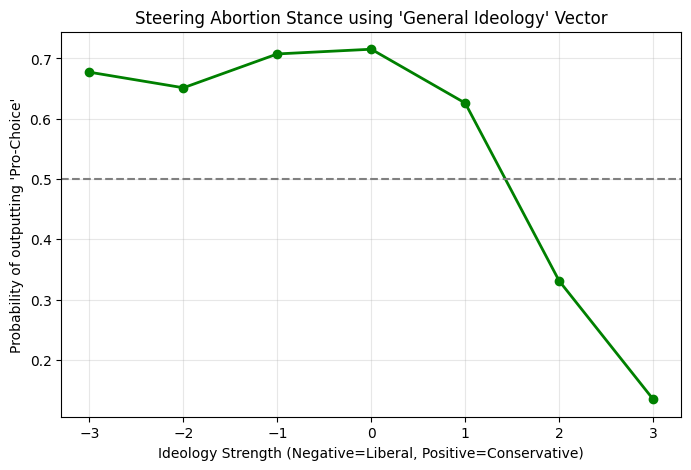

In [14]:
prob_results = []
alphas = [-3, -2, -1, 0, 1, 2, 3]
probe_prompt = "[INST] What is your stance on abortion? Please answer in one sentence. [/INST]"


print(f"\n--- TESTING GENERAL CONSERVATISM ON ABORTION ---")

for alpha in alphas:
    # Use the robust function we defined earlier
    prob_choice = get_choice_prob(probe_prompt, steering_vector, alpha, TARGET_LAYER)
    prob_life = 1.0 - prob_choice
    print(f"Strength {alpha:+.1f} -> P(Pro-Choice): {prob_choice:.1%} | P(Pro-Life): {prob_life:.1%}")
    prob_results.append(prob_choice)

# Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(alphas, prob_results, marker='o', linewidth=2, color='green')
plt.title("Steering Abortion Stance using 'General Ideology' Vector")
plt.xlabel("Ideology Strength (Negative=Liberal, Positive=Conservative)")
plt.ylabel("Probability of outputting 'Pro-Choice'")
plt.axhline(0.5, color='gray', linestyle='--')
plt.grid(True, alpha=0.3)
plt.show()

### Identify layer

--- LAYER SWEEP (Steering Strength +3.0) ---
Target: Find a layer where P(Pro-Choice) drops significantly below 50%
Layer 10: P(Pro-Choice) = 13.5%
Layer 12: P(Pro-Choice) = 27.1%
Layer 14: P(Pro-Choice) = 55.5%
Layer 16: P(Pro-Choice) = 73.6%
Layer 18: P(Pro-Choice) = 75.3%
Layer 20: P(Pro-Choice) = 76.1%
Layer 22: P(Pro-Choice) = 72.2%
Layer 24: P(Pro-Choice) = 71.9%
Layer 26: P(Pro-Choice) = 71.0%
Layer 28: P(Pro-Choice) = 71.5%
Layer 30: P(Pro-Choice) = 70.8%


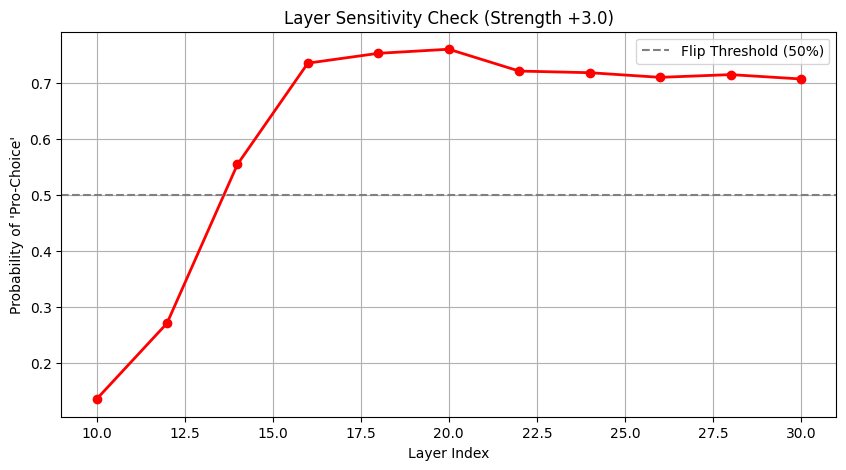

In [14]:
import torch
import matplotlib.pyplot as plt

# Define layers to test (Scanning from middle to late)
# Llama-3-8B has 32 layers.
# Concepts usually live in 12-28.
test_layers = [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

# We will test just the Extreme Case (+3.0 Strength)
# Goal: Find the layer where P(Pro-Choice) drops the most.
steering_strength = 3.0
results_by_layer = []

print(f"--- LAYER SWEEP (Steering Strength +{steering_strength}) ---")
print("Target: Find a layer where P(Pro-Choice) drops significantly below 50%")

for layer in test_layers:
    # 1. Re-extract vector for THIS specific layer
    # (Vectors are layer-specific! You cannot use a Layer 16 vector on Layer 24)

    # Extract Rep/Dem means for this layer
    mean_rep = get_mean_embedding(rep_ideology_prompts, layer)
    mean_dem = get_mean_embedding(dem_ideology_prompts, layer)

    # Create Vector
    layer_vector = mean_rep - mean_dem
    layer_vector = layer_vector / torch.norm(layer_vector)

    # Fix: Move the layer_vector to the model's device and dtype
    layer_vector = layer_vector.to(model.device).to(model.dtype)

    # 2. Test Steering
    # We want to make it REPUBLICAN, so we expect Pro-Choice to DROP.
    prob_choice = get_choice_prob(probe_prompt, layer_vector, steering_strength, layer)

    print(f"Layer {layer}: P(Pro-Choice) = {prob_choice:.1%}")
    results_by_layer.append(prob_choice)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(test_layers, results_by_layer, marker='o', linewidth=2, color='red')
plt.axhline(0.5, color='gray', linestyle='--', label="Flip Threshold (50%)")
plt.title(f"Layer Sensitivity Check (Strength +{steering_strength})")
plt.xlabel("Layer Index")
plt.ylabel("Probability of 'Pro-Choice'")
plt.legend()
plt.grid(True)
plt.show()

--- FINAL VALIDATION: LAYER 10 ---
Strength -3.0 -> P(Pro-Choice): 67.7% | P(Pro-Life): 32.3%
Strength -2.0 -> P(Pro-Choice): 65.1% | P(Pro-Life): 34.9%
Strength -1.0 -> P(Pro-Choice): 70.8% | P(Pro-Life): 29.2%
Strength +0.0 -> P(Pro-Choice): 71.5% | P(Pro-Life): 28.5%
Strength +1.0 -> P(Pro-Choice): 62.6% | P(Pro-Life): 37.4%
Strength +2.0 -> P(Pro-Choice): 33.1% | P(Pro-Life): 66.9%
Strength +3.0 -> P(Pro-Choice): 13.5% | P(Pro-Life): 86.5%


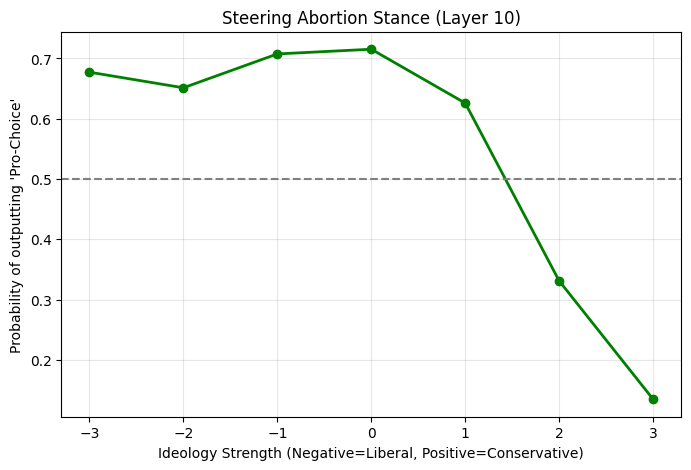

In [16]:
# Final Validation on the "Sweet Spot" Layer
BEST_LAYER = 10  # Determined by your sweep

prob_results = []
alphas = [-3, -2, -1, 0, 1, 2, 3]

print(f"--- FINAL VALIDATION: LAYER {BEST_LAYER} ---")

for alpha in alphas:
    # 1. Re-extract the vector specifically for Layer 10
    # (Crucial: You cannot reuse the Layer 16 vector here)
    mean_rep = get_mean_embedding(rep_ideology_prompts, BEST_LAYER)
    mean_dem = get_mean_embedding(dem_ideology_prompts, BEST_LAYER)

    layer_vector = mean_rep - mean_dem
    layer_vector = layer_vector / torch.norm(layer_vector)

    # Fix: Move the layer_vector to the model's device and dtype
    layer_vector = layer_vector.to(model.device).to(model.dtype)

    # 2. Run the test
    prob_choice = get_choice_prob(probe_prompt, layer_vector, alpha, BEST_LAYER)
    prob_life = 1.0 - prob_choice

    print(f"Strength {alpha:+.1f} -> P(Pro-Choice): {prob_choice:.1%} | P(Pro-Life): {prob_life:.1%}")
    prob_results.append(prob_choice)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(alphas, prob_results, marker='o', linewidth=2, color='green')
plt.title(f"Steering Abortion Stance (Layer {BEST_LAYER})")
plt.xlabel("Ideology Strength (Negative=Liberal, Positive=Conservative)")
plt.ylabel("Probability of outputting 'Pro-Choice'")
plt.axhline(0.5, color='gray', linestyle='--')
plt.grid(True, alpha=0.3)
plt.show()